Notebook by: Eunice Ngai 

In [ ]:
# !pip install --upgrade tensorflow
# !pip install tensorflow==2.15  --quiet
!pip install tensorflow  --quiet
!pip install -U tf_keras  --quiet # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install transformers datasets tensorflow  --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [ ]:
# !pip install --upgrade transformers

In [ ]:
# !pip show tensorflow
# !pip show Keras

In [ ]:
import tensorflow as tf
from transformers import TFElectraForSequenceClassification, ElectraTokenizer
from google.colab import drive

import pandas as pd
import numpy as np
import json

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Model Finetuneing

In [ ]:
# Checkpoints and final model
checkpoint_dir = '/content/drive/MyDrive/MIDS/frugal_ai/Eunice/checkpoints'
final_model_path = '/content/drive/MyDrive/MIDS/frugal_ai/Eunice/electra-base-ft5to12-final'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIDS/frugal_ai/Juliana/df_limited.csv')

df_train = df[df['set'] == 'train']
df_test = df[df['set'] == 'test']

In [ ]:
df_train = df_train.sample(frac=1, random_state=266, ignore_index=True)
df_test = df_test.sample(frac=1, random_state=266, ignore_index=True)

In [ ]:
train_X = df_train['quote'].tolist()
train_y = df_train['label'].tolist()

test_X = df_test['quote'].tolist()
test_y = df_test['label'].tolist()

In [ ]:
# Define the label mapping
LABEL_MAPPING = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7
}

# Convert string labels to integers
train_label = list(map(lambda x: LABEL_MAPPING[x], train_y))
test_label = list(map(lambda x: LABEL_MAPPING[x], test_y))

In [ ]:
# https://colab.research.google.com/drive/1VoWyzlXZVR5sNygejktJ4Uguw3HIZckb?usp=sharing

# Load ELECTRA BASE model and tokenizer
model_name = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = TFElectraForSequenceClassification.from_pretrained(model_name, num_labels=8)

#   Freeze the first 4 layers
for layer in model.electra.encoder.layer[:4]:
    layer.trainable = False

#   Train the last 8 layers
for layer in model.electra.encoder.layer[-8:]:
    layer.trainable = True


# tokenize quotes
encoded_quote = tokenizer(train_X,
                          truncation=True,
                          padding="max_length",
                          return_tensors="tf")

# Dictionary with input IDs and attention mask
inputs = {
    'input_ids': encoded_quote['input_ids'],
    'attention_mask': encoded_quote['attention_mask']
}

# Include labels if training
full_dataset = tf.data.Dataset.from_tensor_slices((inputs, tf.constant(train_label))).batch(10)

# Create validation set
# Split into training and validation datasets
train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

# Checkpoints
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'checkpoint_epoch_{epoch}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# default values
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,
                                     epsilon=1e-7,
                                     beta_1=0.9,
                                     beta_2=0.999)

# Compile
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Finetune
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=5,
          callbacks=[checkpoint_callback])

# Save the final model
# model.save_pretrained(final_model_path)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
288/288 [==============================] - ETA: 0s - loss: 1.5452 - accuracy: 0.4135
Epoch 1: val_loss improved from inf to 1.14722, saving model to /content/drive/MyDrive/MIDS/frugal_ai/Eunice/checkpoints/checkpoint_epoch_1.weights.h5
288/288 [==============================] - 99s 233ms/step - loss: 1.5452 - accuracy: 0.4135 - val_loss: 1.1472 - val_accuracy: 0.6092
Epoch 2/5
288/288 [==============================] - ETA: 0s - loss: 0.8931 - accuracy: 0.6986
Epoch 2: val_loss improved from 1.14722 to 0.93828, saving model to /content/drive/MyDrive/MIDS/frugal_ai/Eunice/checkpoints/checkpoint_epoch_2.weights.h5
288/288 [==============================] - 57s 198ms/step - loss: 0.8931 - accuracy: 0.6986 - val_loss: 0.9383 - val_accuracy: 0.6954
Epoch 3/5
288/288 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.8219
Epoch 3: val_loss did not improve from 0.93828
288/288 [==============================] - 46s 160ms/step - loss: 0.5712 - accuracy: 0.8219 - 

In [ ]:
for batch in val_dataset.take(1):
    inputs, labels = batch
    print(inputs)
    print(labels)

{'input_ids': <tf.Tensor: shape=(10, 512), dtype=int32, numpy=
array([[ 101, 1996, 3256, ...,    0,    0,    0],
       [ 101, 2009, 1521, ...,    0,    0,    0],
       [ 101, 2017, 2298, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 9375, ...,    0,    0,    0],
       [ 101, 2065, 1045, ...,    0,    0,    0],
       [ 101, 4661, 2108, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(10, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
tf.Tensor([1 3 5 1 5 3 5 7 3 4], shape=(10,), dtype=int32)


In [ ]:
for batch in train_dataset.take(1):
    inputs, labels = batch
    # try **inputs to expand the dictionary
    outputs = model(**inputs)
    print(outputs.logits)


tf.Tensor(
[[ 0.0525555   0.09919629  0.02518908 -0.11869954  0.02907911  0.03049592]
 [ 0.05557149  0.13033827 -0.00836853 -0.14531834  0.00956786 -0.01710766]
 [ 0.07675572  0.14144127 -0.03362048 -0.13893542  0.00109686  0.00265281]
 [ 0.04502888  0.09992999 -0.01757868 -0.18466137 -0.000925    0.02071026]
 [ 0.02821992  0.11746463 -0.02688191 -0.1840851   0.00602973  0.04273786]
 [ 0.05080915  0.11841306  0.00690543 -0.149228    0.00023179 -0.01302947]
 [ 0.02290859  0.12967727  0.00611281 -0.14893326  0.04576885  0.0094345 ]
 [ 0.11317664  0.106491   -0.0306619  -0.17542063 -0.03916263  0.04533345]
 [ 0.03660445  0.08609073 -0.00394647 -0.14347748 -0.00285449 -0.00064472]
 [ 0.06583001  0.10900719 -0.01281781 -0.15195253  0.01294244  0.00633538]], shape=(10, 6), dtype=float32)


# Results

## Experiment 1
- ELECTRA BASE fine tuned on Frugal AI Dataset  
- Freeze first 6 layers, fine-tune on last 6 layers
- Ran in Google Colab Pro+ on A100 GPU
- Final model weights saved

loss: 2.0515 - accuracy: 0.2476 - val_loss: 2.0354 - val_accuracy: 0.3241

```
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6,
                                     epsilon=1e-7,
                                     beta_1=0.9,
                                     beta_2=0.999)

# Compile
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Finetune
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=3,
          callbacks=[checkpoint_callback])
```




loss: 0.3787 - accuracy: 0.8868 - val_loss: 0.9384 - val_accuracy: 0.7524

```
# default values
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,
                                     epsilon=1e-7,
                                     beta_1=0.9,
                                     beta_2=0.999)

# Compile
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Finetune
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=5,
          callbacks=[checkpoint_callback])
```



In [ ]:
# Model: "tf_electra_for_sequence_classification"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #
# =================================================================
#  electra (TFElectraMainLaye  multiple                  108891648
#  r)

#  classifier (TFElectraClass  multiple                  592130
#  ificationHead)

# =================================================================
# Total params: 109483778 (417.65 MB)
# Trainable params: 66956546 (255.42 MB)
# Non-trainable params: 42527232 (162.23 MB)
# _________________________________________________________________

Model: "tf_electra_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLaye  multiple                  108891648 
 r)                                                              
                                                                 
 classifier (TFElectraClass  multiple                  596744    
 ificationHead)                                                  
                                                                 
Total params: 109488392 (417.67 MB)
Trainable params: 66961160 (255.44 MB)
Non-trainable params: 42527232 (162.23 MB)
_________________________________________________________________


## Experiment 2

### Final Saved Model
Train last 8 layers, freeze first 4 layers.

Epoch 5/5
288/288 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9194
Epoch 5: val_loss improved from 0.93828 to 0.87218, saving model to /content/drive/MyDrive/MIDS/frugal_ai/Eunice/checkpoints/checkpoint_epoch_5.weights.h5

```

# default values
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,
                                     epsilon=1e-7,
                                     beta_1=0.9,
                                     beta_2=0.999)

# Compile
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Finetune
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=5,
          callbacks=[checkpoint_callback])
```

In [ ]:
model.summary()

# Model: "tf_electra_for_sequence_classification_5"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #
# =================================================================
#  electra (TFElectraMainLaye  multiple                  108891648
#  r)

#  classifier (TFElectraClass  multiple                  596744
#  ificationHead)

# =================================================================
# Total params: 109488392 (417.67 MB)
# Trainable params: 81136904 (309.51 MB)
# Non-trainable params: 28351488 (108.15 MB)
# _________________________________________________________________

Model: "tf_electra_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLaye  multiple                  108891648 
 r)                                                              
                                                                 
 classifier (TFElectraClass  multiple                  596744    
 ificationHead)                                                  
                                                                 
Total params: 109488392 (417.67 MB)
Trainable params: 81136904 (309.51 MB)
Non-trainable params: 28351488 (108.15 MB)
_________________________________________________________________


##Evaluation

In [ ]:
# https://colab.research.google.com/drive/1VoWyzlXZVR5sNygejktJ4Uguw3HIZckb?usp=sharing

# Load saved ELECTRA fine-tuned model
model_name = "google/electra-base-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_name)
# Load model path
load_model_path = '/content/drive/MyDrive/MIDS/frugal_ai/Eunice/electra-base-ft5to12-final'

# Load model config and weights
model = TFElectraForSequenceClassification.from_pretrained(load_model_path)


# tokenize quotes
encoded_quote = tokenizer(test_X,
                          truncation=True,
                          padding="max_length",
                          return_tensors="tf")

# Dictionary with input IDs and attention mask
inputs = {
    'input_ids': encoded_quote['input_ids'],
    'attention_mask': encoded_quote['attention_mask']
}

# prepare dataset for inference
input_data = tf.data.Dataset.from_tensor_slices(inputs).batch(10)

# inference
predictions = model.predict(input_data)
pred_labels = np.argmax(predictions.logits, axis=1)
print(pred_labels.shape)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/MIDS/frugal_ai/Eunice/electra-base-ft7to12-final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


95/95 [==============================] - 14s 58ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[-0.97335136,  0.19210993,  0.8951237 , ...,  5.217942  ,
         0.4518316 , -3.6469686 ],
       [ 0.4627358 , -2.0689015 , -1.8794866 , ..., -1.5496056 ,
        -1.1216714 ,  0.8779483 ],
       [-0.01018563, -1.6446098 , -0.39611784, ...,  2.1064863 ,
        -1.4330555 , -2.3599741 ],
       ...,
       [-0.8540842 , -1.7609339 , -1.2608944 , ..., -2.4801772 ,
        -0.3532726 ,  5.519019  ],
       [-0.4434059 ,  6.4427257 ,  0.5300827 , ..., -1.1158396 ,
        -2.0552487 , -2.9085915 ],
       [-0.44444105,  6.455983  ,  0.55606616, ..., -0.75770533,
        -1.7164105 , -2.8812244 ]], dtype=float32), hidden_states=None, attentions=None)


In [ ]:
# np.save('/content/drive/MyDrive/MIDS/frugal_ai/Eunice/pred_labels.npy', pred_labels)
# np.save('/content/drive/MyDrive/MIDS/frugal_ai/Eunice/true_labels.npy', test_label)

pred_labels = np.load('/content/drive/MyDrive/MIDS/frugal_ai/Eunice/pred_labels.npy')
test_labels = np.load('/content/drive/MyDrive/MIDS/frugal_ai/Eunice/true_labels.npy')

In [ ]:
# Define the label mapping
LABEL_MAPPING = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7
}

REV_MAPPING = {value: key for key, value in LABEL_MAPPING.items()}

# Convert integers to string labels
map_label = lambda x: REV_MAPPING[x]

labels = np.array(list(map(map_label, test_label)))
pred_labels = np.array([map_label(x) for x in pred_labels])

print(np.unique(labels))
print(np.unique(pred_labels))

Text(50.5815972222222, 0.5, 'True')

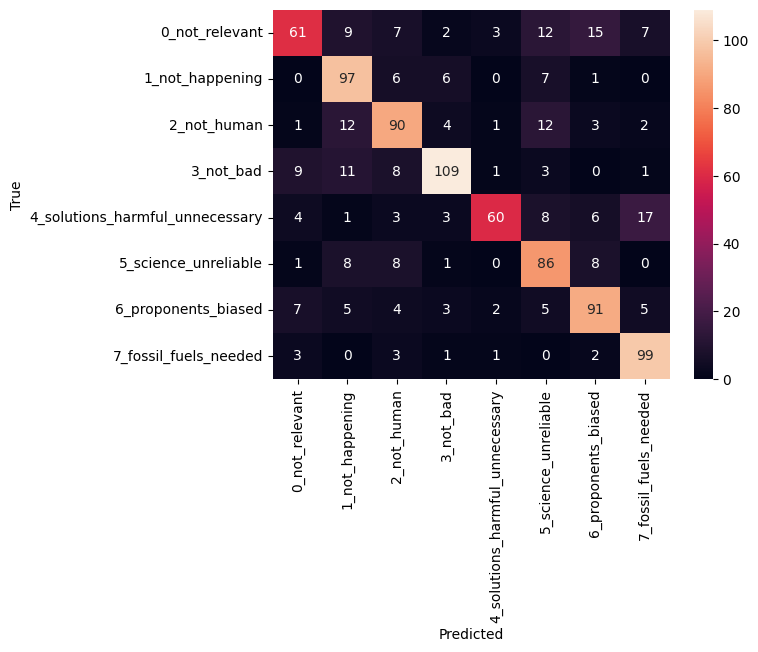

In [ ]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                                 precision    recall  f1-score   support

                 0_not_relevant     0.7093    0.5259    0.6040       116
                1_not_happening     0.6783    0.8291    0.7462       117
                    2_not_human     0.6977    0.7200    0.7087       125
                      3_not_bad     0.8450    0.7676    0.8044       142
4_solutions_harmful_unnecessary     0.8824    0.5882    0.7059       102
           5_science_unreliable     0.6466    0.7679    0.7020       112
            6_proponents_biased     0.7222    0.7459    0.7339       122
          7_fossil_fuels_needed     0.7557    0.9083    0.8250       109

                       accuracy                         0.7333       945
                      macro avg     0.7421    0.7316    0.7287       945
                   weighted avg     0.7426    0.7333    0.7304       945

